# Spotify Popularity Prediction


##Project Objective: Predicting Song Popularity on Spotify

We are part of the Data Analytics team at Spotify. Our objective is to build a predictive model that estimates a song’s popularity using its audio and metadata features. This will allow Spotify and its partner artists to:

- Identify key audio characteristics of hit songs
- Optimize track production and release strategies
- Improve playlist curation and algorithmic promotion

We focus on **Track 2: Popularity Prediction**, aiming to answer:
1. Can we accurately predict a song’s popularity score based on its features?
2. What are the most important factors that drive popularity?
3. How can artists and producers use this to shape musical decisions?


## Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Data Collection and Preparation

##Dataset Overview

- **Source:** [Kaggle Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)
- **Size:** ~114,000 songs
- **Features:** 21 columns, including:
  - Audio features: danceability, energy, valence, tempo, etc.
  - Metadata: genre, explicit, song duration, etc.
  - Target: **Popularity** score (0–100), derived from listening behavior

This dataset allows us to explore correlations between musical features and song success.


In [ ]:
print('Dataset Source: Kaggle Spotify Tracks Dataset')
print('Contains ~114,000 tracks across 125+ genres with audio features')
print('Features include: acousticness, danceability, energy, popularity, etc.')

try:
    # Load data with error handling
    df = pd.read_csv('sample_data/dataset.csv')
    print(f'Dataset loaded successfully')
    print(f'Original dataset shape: {df.shape}')
except FileNotFoundError:
    print('Dataset file not found. Please ensure \'dataset.csv\' is in the correct path.')
    raise

# Drop unnecessary column
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Drop missing values
df.dropna(inplace=True)

# Remove duplicates
original_size = len(df)
df = df.drop_duplicates()
duplicates_removed = original_size - len(df)
print(f'Removed {duplicates_removed:,} duplicate records')
print(f'After removing duplicates: {df.shape}')

# Basic info
print(f'\nDataset Overview:')
print(f'- Total songs: {len(df):,}')
print(f'- Features: {df.shape[1]}')
print(f'- Missing values: {df.isnull().sum().sum()}')

# Display first few rows
print(f'\nFirst 5 rows:')
display(df.head())


Dataset Source: Kaggle Spotify Tracks Dataset
Contains ~114,000 tracks across 125+ genres with audio features
Features include: acousticness, danceability, energy, popularity, etc.
Dataset loaded successfully
Original dataset shape: (95262, 21)
Removed 438 duplicate records
After removing duplicates: (94822, 20)

Dataset Overview:
- Total songs: 94,822
- Features: 20
- Missing values: 0

First 5 rows:


,song_id,artists,album_name,song_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,song_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4.0,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4.0,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4.0,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3.0,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4.0,acoustic


## 2. Data Exploration - Target Variable Analysis

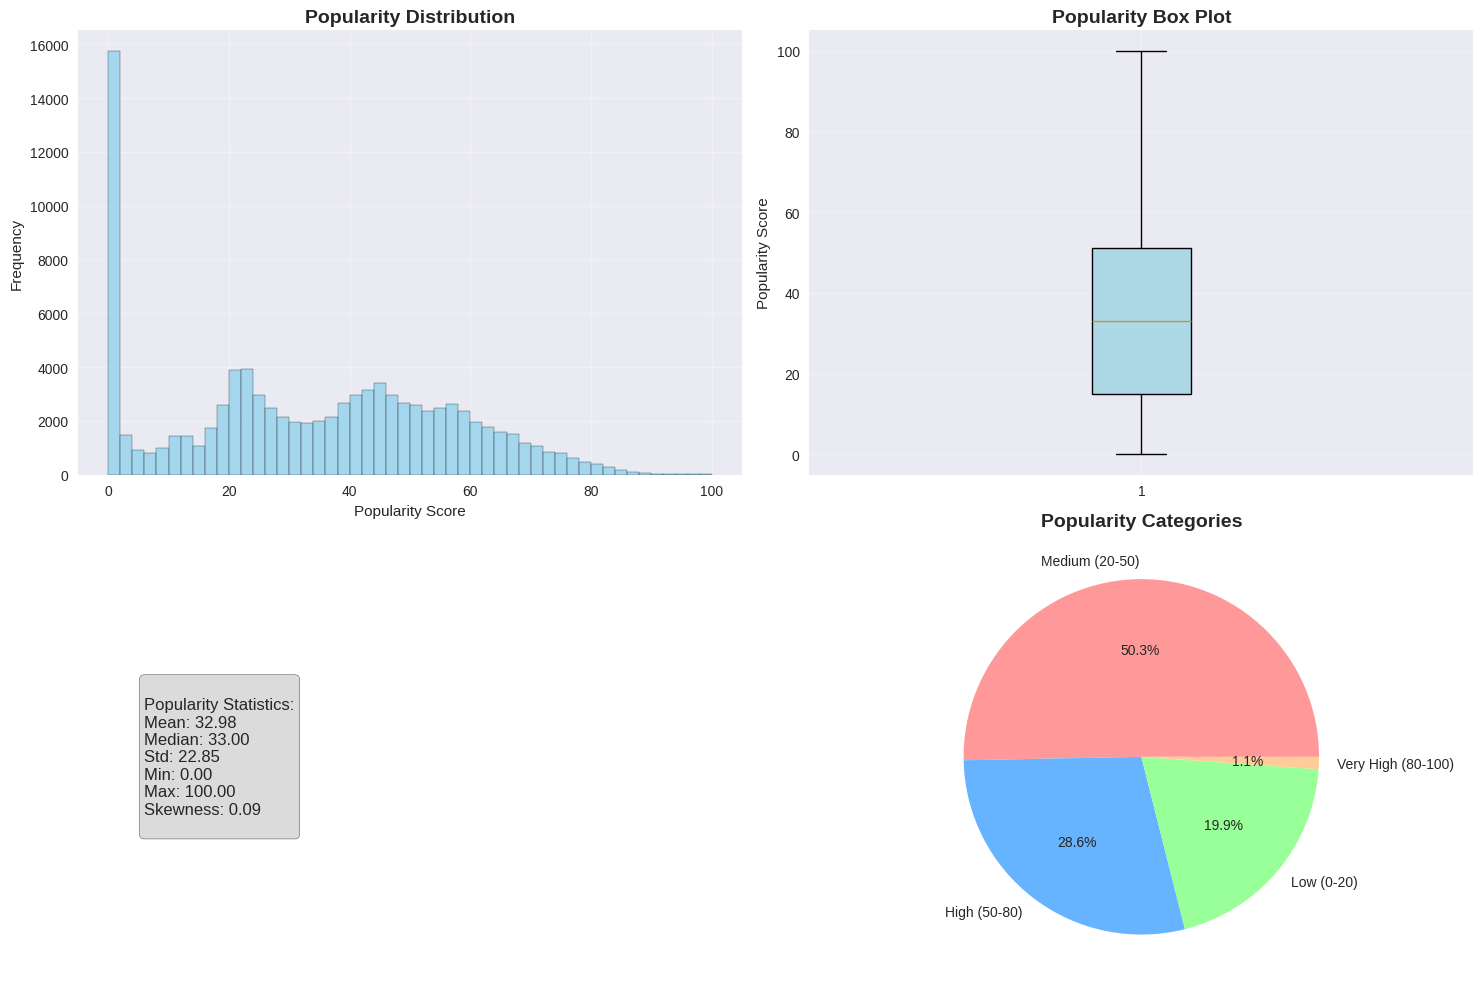


 Key Insights from Target Analysis:
- Average popularity: 32.98
- Most songs have low popularity (0-20): 29,994 songs (31.6%)
- Very few songs are highly popular (>80): 901 songs (1.0%)
- Distribution is heavily right-skewed: 0.09
- This skewed distribution is typical for popularity metrics in entertainment


In [ ]:
# Popularity distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0,0].hist(df['popularity'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Popularity Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Popularity Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Box plot
bp = axes[0,1].boxplot(df['popularity'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0,1].set_title('Popularity Box Plot', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Popularity Score')
axes[0,1].grid(True, alpha=0.3)

# Descriptive statistics
pop_stats = df['popularity'].describe()
axes[1,0].text(0.1, 0.5, f"""
Popularity Statistics:
Mean: {pop_stats['mean']:.2f}
Median: {pop_stats['50%']:.2f}
Std: {pop_stats['std']:.2f}
Min: {pop_stats['min']:.2f}
Max: {pop_stats['max']:.2f}
Skewness: {df['popularity'].skew():.2f}
""", transform=axes[1,0].transAxes, fontsize=12, verticalalignment='center',
bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
axes[1,0].axis('off')

# Popularity categories
df['pop_category'] = pd.cut(df['popularity'],
                           bins=[0, 20, 50, 80, 100],
                           labels=['Low (0-20)', 'Medium (20-50)', 'High (50-80)', 'Very High (80-100)'])
pop_counts = df['pop_category'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
axes[1,1].pie(pop_counts.values, labels=pop_counts.index, autopct='%1.1f%%', colors=colors)
axes[1,1].set_title('Popularity Categories', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print(f'\n Key Insights from Target Analysis:')
print(f'- Average popularity: {df["popularity"].mean():.2f}')
print(f'- Most songs have low popularity (0-20): {(df["popularity"] <= 20).sum():,} songs ({(df["popularity"] <= 20).mean()*100:.1f}%)')
print(f'- Very few songs are highly popular (>80): {(df["popularity"] > 80).sum():,} songs ({(df["popularity"] > 80).mean()*100:.1f}%)')
print(f'- Distribution is heavily right-skewed: {df["popularity"].skew():.2f}')
print(f'- This skewed distribution is typical for popularity metrics in entertainment')

## 3. Feature Exploration and Selection

Missing values per column:
pop_category    13844
dtype: int64
Dropped 13844 rows with missing values
Final dataset shape: (80978, 17)


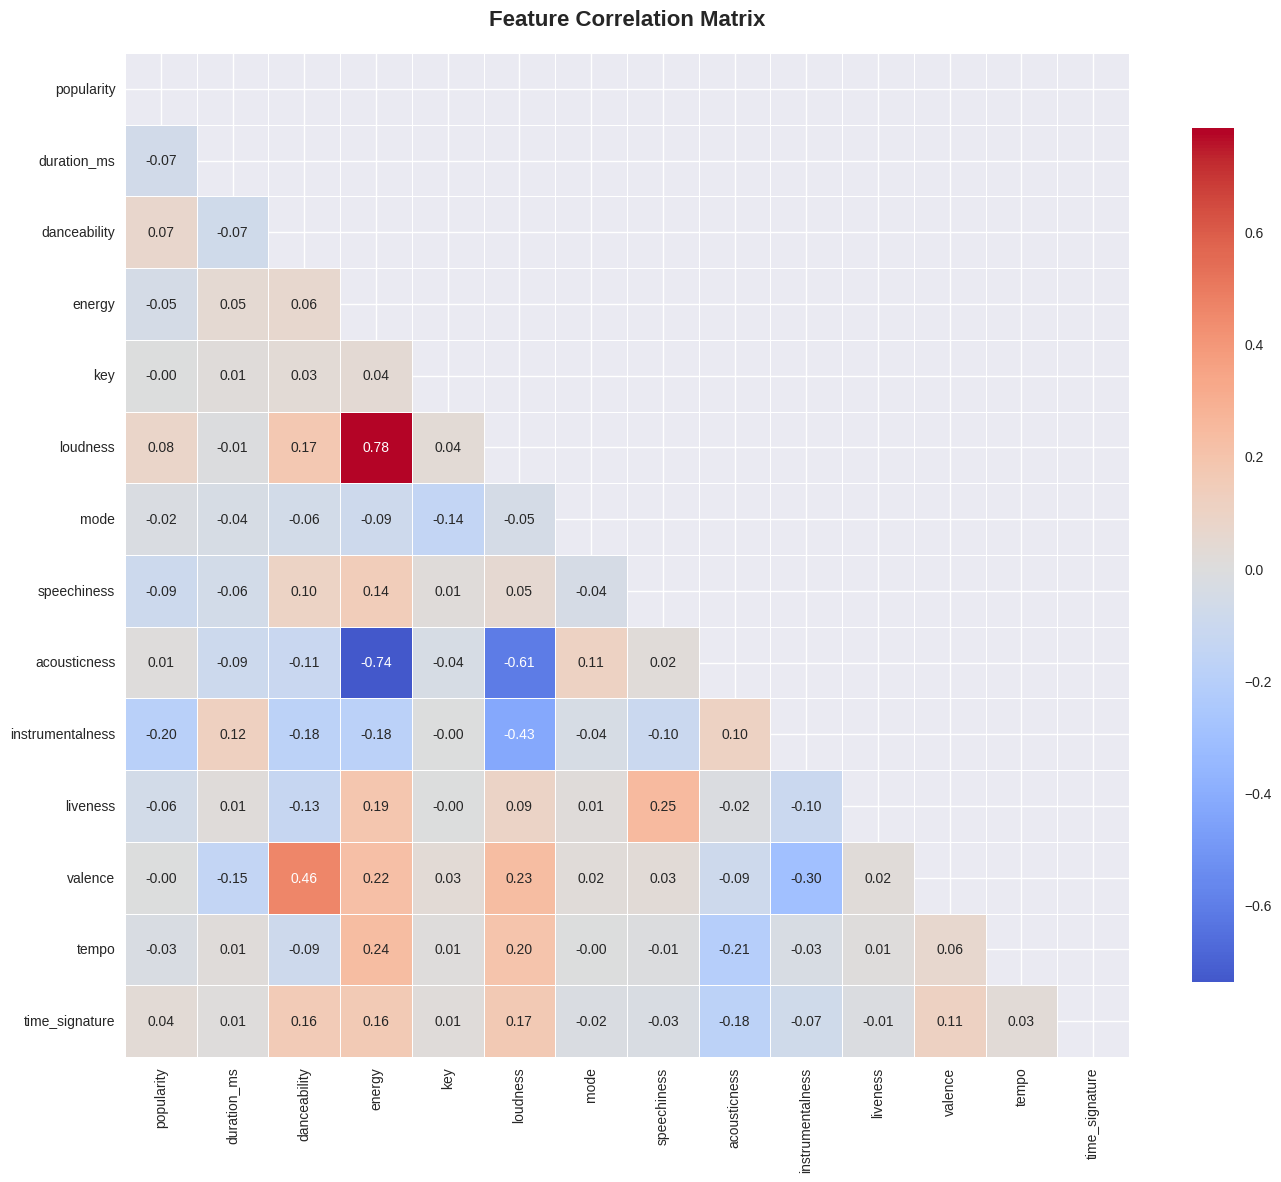


 Features Correlation with Popularity:
instrumentalness: -0.196 (Moderate Negative)
speechiness    : -0.092 (Weak Negative)
loudness       :  0.080 (Weak Positive)
danceability   :  0.071 (Weak Positive)
duration_ms    : -0.066 (Weak Negative)
liveness       : -0.061 (Weak Negative)
energy         : -0.049 (Weak Negative)
time_signature :  0.036 (Weak Positive)
tempo          : -0.026 (Weak Negative)
mode           : -0.020 (Weak Negative)
acousticness   :  0.010 (Weak Positive)
key            : -0.005 (Weak Negative)
valence        : -0.001 (Weak Negative)


In [ ]:
# Clean dataset - remove unnecessary columns
cols_to_drop = ['Unnamed: 0', 'song_id', 'album_name', 'song_name', 'artists']
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df_clean = df.drop(columns=cols_to_drop)

# Handle missing values
print(f'Missing values per column:')
missing_vals = df_clean.isnull().sum()
missing_summary = missing_vals[missing_vals > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print('No missing values found')

# Drop rows with missing values if any
initial_rows = len(df_clean)
df_clean = df_clean.dropna()
rows_dropped = initial_rows - len(df_clean)
if rows_dropped > 0:
    print(f'Dropped {rows_dropped} rows with missing values')
print(f'Final dataset shape: {df_clean.shape}')

# Correlation analysis
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
corr_matrix = df_clean[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation with popularity specifically
pop_corr = corr_matrix['popularity'].sort_values(key=abs, ascending=False)[1:]  # Exclude self-correlation
print(f'\n Features Correlation with Popularity:')
print('='*40)
for feature, corr_val in pop_corr.items():
    strength = 'Strong' if abs(corr_val) > 0.3 else 'Moderate' if abs(corr_val) > 0.1 else 'Weak'
    direction = 'Positive' if corr_val > 0 else 'Negative'
    print(f'{feature:15s}: {corr_val:6.3f} ({strength} {direction})')

## 4. Genre Analysis Integration

Top 10 Genres by Average Popularity (min 100 songs):
             mean  median  count    std
song_genre                             
pop-film    59.40    60.0    997   9.91
k-pop       59.22    61.0    960  12.73
pop         58.37    67.0    815  28.14
electro     58.00    67.0    622  25.22
house       57.31    66.0    596  25.30
chill       55.89    57.0    960  10.38
edm         55.04    63.0    634  24.70
metal       54.97    64.0    793  22.64
indie-pop   54.87    58.0    741  19.37
indie       54.48    54.0    712  20.58

Bottom 10 Genres by Average Popularity (min 100 songs):
                 mean  median  count    std
song_genre                                 
latin           20.44     2.0    405  30.72
breakbeat       20.19    14.0    996  12.83
honky-tonk      16.41    13.0    981   9.20
idm             15.98    12.0    984  10.16
kids            15.37    12.0    963   9.03
grindcore       14.67    14.0    995   4.44
chicago-house   12.38    10.0    994   9.58
detroit-techno

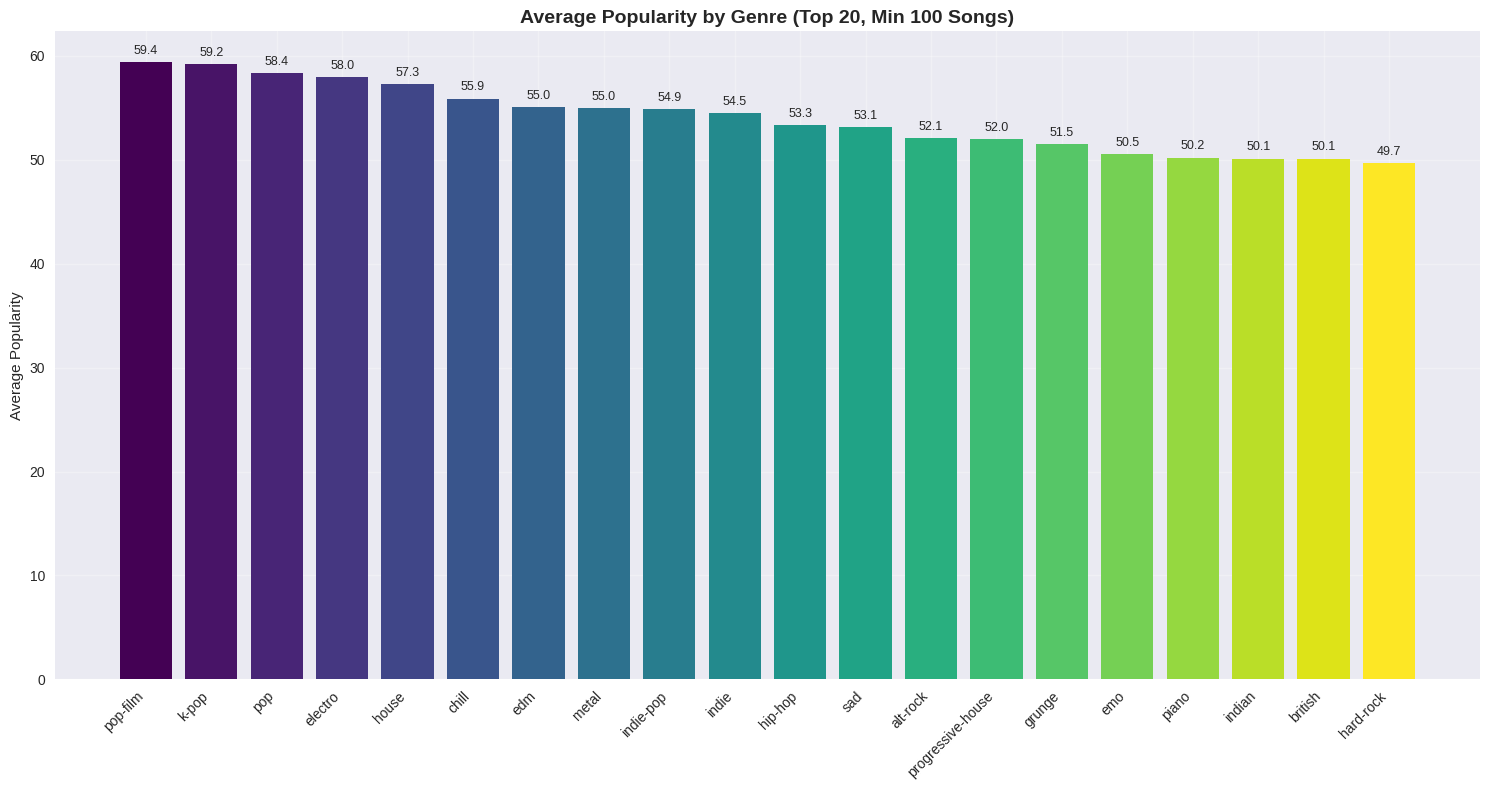


 Genre Insights:
- Total genres: 96
- Most popular genre: pop-film (avg: 59.4)
- Least popular genre: iranian (avg: 6.5)


In [ ]:
if 'song_genre' in df_clean.columns:
    # Genre popularity analysis
    genre_stats = df_clean.groupby('song_genre')['popularity'].agg(['mean', 'median', 'count', 'std']).round(2)
    genre_stats = genre_stats.sort_values('mean', ascending=False)

    # Filter genres with sufficient sample size (at least 100 songs)
    genre_stats_filtered = genre_stats[genre_stats['count'] >= 100]

    print('Top 10 Genres by Average Popularity (min 100 songs):')
    print(genre_stats_filtered.head(10))

    print('\nBottom 10 Genres by Average Popularity (min 100 songs):')
    print(genre_stats_filtered.tail(10))

    # Create genre encoding for modeling
    genre_encoder = LabelEncoder()
    df_clean['genre_encoded'] = genre_encoder.fit_transform(df_clean['song_genre'])

    # Plot genre popularity
    plt.figure(figsize=(15, 8))
    top_genres = genre_stats_filtered.head(20)
    bars = plt.bar(range(len(top_genres)), top_genres['mean'],
                   color=plt.cm.viridis(np.linspace(0, 1, len(top_genres))))
    plt.xticks(range(len(top_genres)), top_genres.index, rotation=45, ha='right')
    plt.title('Average Popularity by Genre (Top 20, Min 100 Songs)', fontsize=14, fontweight='bold')
    plt.ylabel('Average Popularity')
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f'\n Genre Insights:')
    print(f'- Total genres: {df_clean["song_genre"].nunique()}')
    print(f'- Most popular genre: {genre_stats_filtered.iloc[0].name} (avg: {genre_stats_filtered.iloc[0]["mean"]:.1f})')
    print(f'- Least popular genre: {genre_stats_filtered.iloc[-1].name} (avg: {genre_stats_filtered.iloc[-1]["mean"]:.1f})')

## 5. Feature Relationships with Popularity

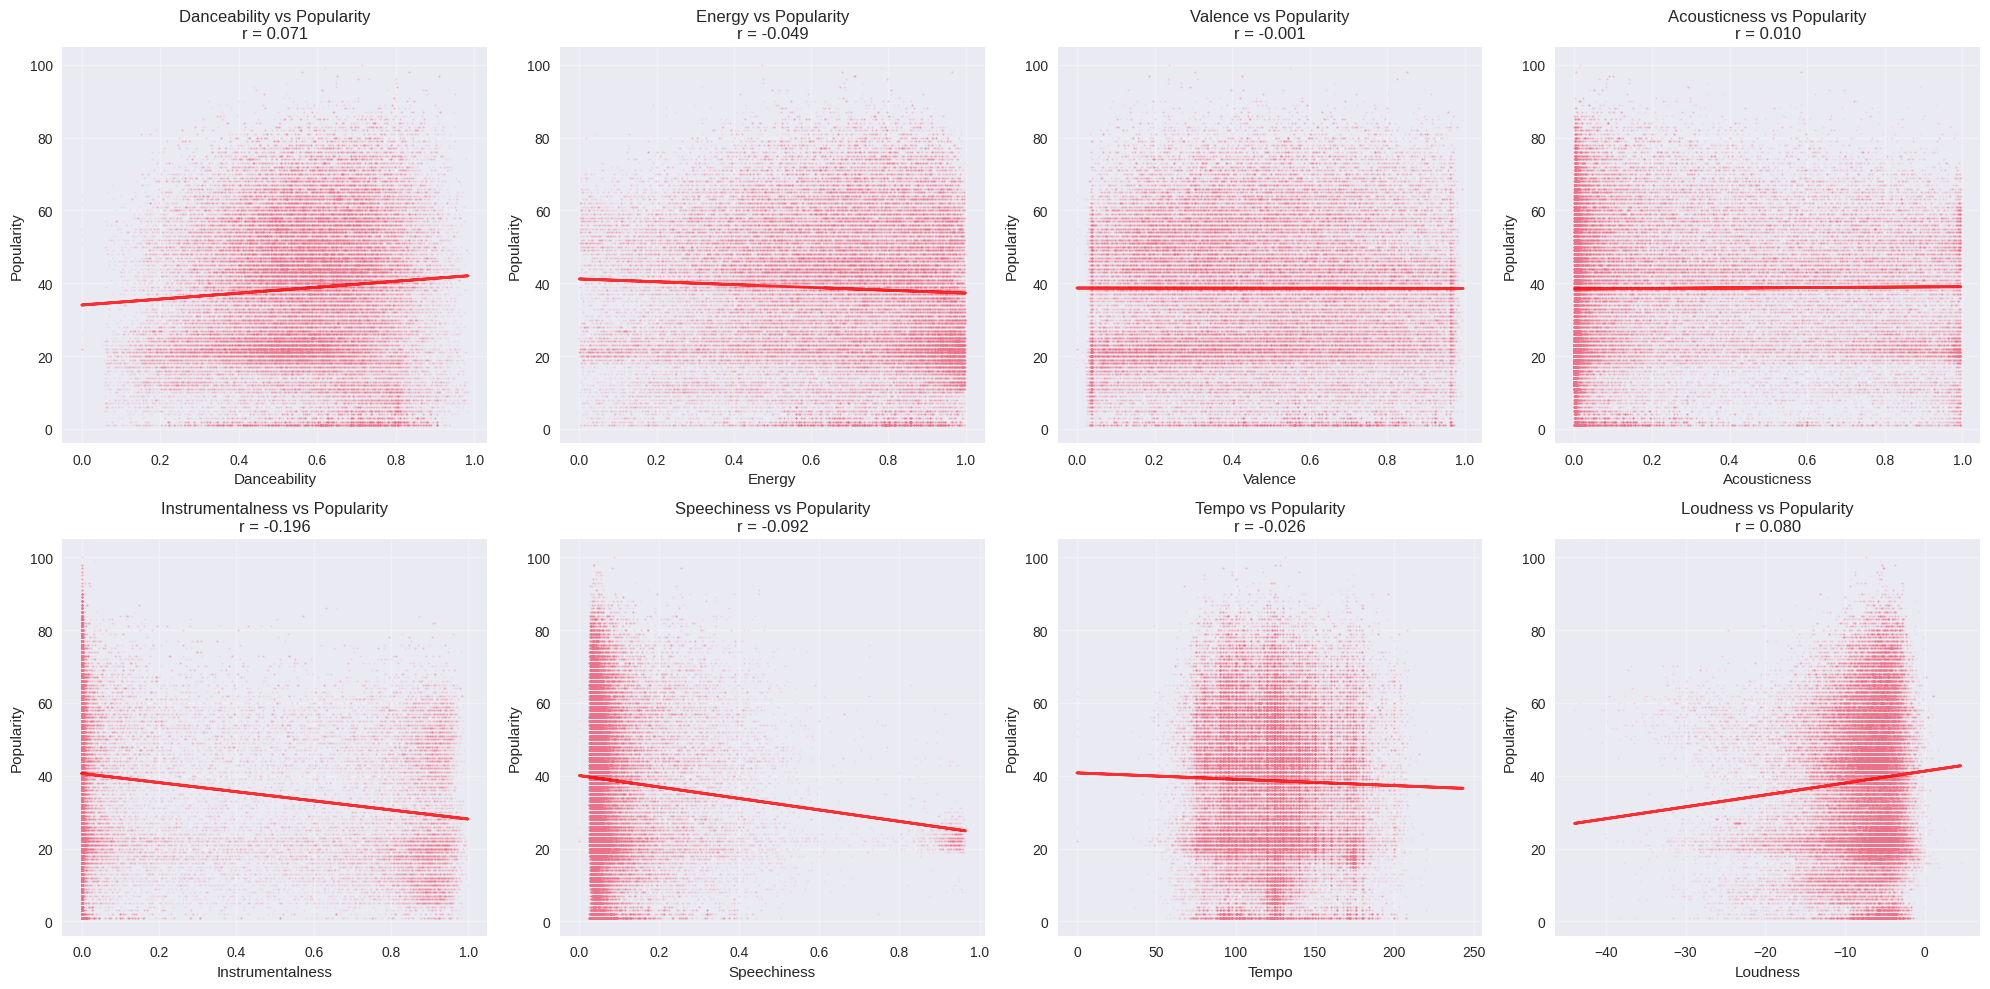

In [ ]:
# Select key audio features for analysis
audio_features = ['danceability', 'energy', 'valence', 'acousticness',
                 'instrumentalness', 'speechiness', 'tempo', 'loudness']

# Create scatter plots with enhanced visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(audio_features):
    if feature in df_clean.columns:
        # Create scatter plot with alpha blending
        axes[i].scatter(df_clean[feature], df_clean['popularity'], alpha=0.1, s=1)
        axes[i].set_xlabel(feature.title())
        axes[i].set_ylabel('Popularity')
        axes[i].set_title(f'{feature.title()} vs Popularity\nr = {corr_matrix.loc[feature, "popularity"]:.3f}')
        axes[i].grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df_clean[feature], df_clean['popularity'], 1)
        p = np.poly1d(z)
        axes[i].plot(df_clean[feature], p(df_clean[feature]), 'r-', alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

## 6. Feature Engineering

##Feature Engineering

To enhance predictive power, we created new features using domain knowledge:

- `energy_danceability`: captures how danceable high-energy tracks are
- `valence_energy`: blends emotion and intensity
- `tempo_danceability`: reflects rhythmic accessibility
- `is_explicit`: binary flag for explicit lyrics
- `is_major`: major (1) vs. minor (0) mode
- `tempo_category`: groups tempo into bins (slow, medium, fast)

These engineered features aim to capture richer musical patterns.


In [ ]:
# Create interaction features based on domain knowledge
df_clean['energy_danceability'] = df_clean['energy'] * df_clean['danceability']
df_clean['valence_energy'] = df_clean['valence'] * df_clean['energy']
df_clean['tempo_danceability'] = df_clean['tempo'] * df_clean['danceability']

# Create categorical features
df_clean['is_explicit'] = df_clean['explicit'].astype(int) if 'explicit' in df_clean.columns else 0
df_clean['is_major'] = df_clean['mode'] if 'mode' in df_clean.columns else 0

# Create tempo categories
if 'tempo' in df_clean.columns:
    df_clean['tempo_category'] = pd.cut(df_clean['tempo'],
                                       bins=[0, 90, 120, 140, 200],
                                       labels=['Slow', 'Medium', 'Fast', 'Very Fast'])

print('Created engineered features:')
print('- energy_danceability: Energy × Danceability')
print('- valence_energy: Valence × Energy')
print('- tempo_danceability: Tempo × Danceability')
print('- is_explicit: Binary explicit content indicator')
print('- is_major: Major/minor mode indicator')
print('- tempo_category: Categorical tempo grouping')

# Show correlation of new features with popularity
new_features = ['energy_danceability', 'valence_energy', 'tempo_danceability']
print(f'\n New Feature Correlations with Popularity:')
for feature in new_features:
    if feature in df_clean.columns:
        corr_val = df_clean[feature].corr(df_clean['popularity'])
        print(f'{feature:20s}: {corr_val:.3f}')

Created engineered features:
- energy_danceability: Energy × Danceability
- valence_energy: Valence × Energy
- tempo_danceability: Tempo × Danceability
- is_explicit: Binary explicit content indicator
- is_major: Major/minor mode indicator
- tempo_category: Categorical tempo grouping

 New Feature Correlations with Popularity:
energy_danceability : 0.000
valence_energy      : -0.018
tempo_danceability  : 0.033


## 7. Model Preparation and Training

##Model Selection & Rationale

We evaluated four models:

- **Dummy Regressor (Mean)**: Baseline benchmark
- **Linear Regression**: Simple, interpretable model
- **Decision Tree**: Handles non-linear relationships and interactions
- **Random Forest**: Ensemble method with strong generalization and feature importance analysis

We chose **Random Forest** as our primary model because it:
- Had the highest R² on test and CV sets
- Balanced accuracy and interpretability
- Naturally handled both linear and non-linear patterns


In [ ]:

# Feature selection based on correlation and domain knowledge
selected_features = ['danceability', 'energy', 'loudness', 'valence', 'tempo',
                    'acousticness', 'instrumentalness', 'speechiness',
                    'energy_danceability', 'valence_energy', 'is_explicit']

# Add genre encoding if available
if 'genre_encoded' in df_clean.columns:
    selected_features.append('genre_encoded')

# Filter features that exist in dataset
selected_features = [f for f in selected_features if f in df_clean.columns]
print(f'Selected features ({len(selected_features)}): {selected_features}')

# Prepare data
X = df_clean[selected_features]
y = df_clean['popularity']

print(f'\n Data Preparation Summary:')
print(f'- Feature matrix shape: {X.shape}')
print(f'- Target vector shape: {y.shape}')
print(f'- Feature types: {X.dtypes.value_counts().to_dict()}')

# Split data with stratification by popularity quartiles
y_quartiles = pd.qcut(y, q=4, labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_quartiles
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  IMPROVE AND CONTINUE FROM HERE
print(f'\n Data Split Complete:')
print(f'- Training set: {X_train.shape[0]:,} samples')
print(f'- Test set: {X_test.shape[0]:,} samples')
print(f'- Training popularity range: {y_train.min():.1f} - {y_train.max():.1f}')
print(f'- Test popularity range: {y_test.min():.1f} - {y_test.max():.1f}')

Selected features (12): ['danceability', 'energy', 'loudness', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness', 'energy_danceability', 'valence_energy', 'is_explicit', 'genre_encoded']

 Data Preparation Summary:
- Feature matrix shape: (80978, 12)
- Target vector shape: (80978,)
- Feature types: {dtype('float64'): 10, dtype('int64'): 2}

 Data Split Complete:
- Training set: 64,782 samples
- Test set: 16,196 samples
- Training popularity range: 1.0 - 100.0
- Test popularity range: 1.0 - 97.0


## 8. Model Comparison with Cross-Validation

In [ ]:
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

Training models and performing cross-validation...

 Training Baseline (Mean)
  Test Set Performance:
    RMSE: 19.78
    MAE:  16.61
    R²:   -0.0000
  Cross-Validation (5-fold):
    R² Score: -0.0001 (±0.0000)
    RMSE:     19.85 (±0.09)

 Training Linear Regression
  Test Set Performance:
    RMSE: 19.07
    MAE:  15.62
    R²:   0.0709
  Cross-Validation (5-fold):
    R² Score: 0.0806 (±0.0037)
    RMSE:     19.04 (±0.07)

 Training Decision Tree
  Test Set Performance:
    RMSE: 16.80
    MAE:  12.55
    R²:   0.2791
  Cross-Validation (5-fold):
    R² Score: 0.2640 (±0.0069)
    RMSE:     17.03 (±0.14)

 Training Random Forest
  Test Set Performance:
    RMSE: 15.16
    MAE:  11.09
    R²:   0.4129
  Cross-Validation (5-fold):
    R² Score: 0.4123 (±0.0069)
    RMSE:     15.22 (±0.11)

 Training XGBoost
  Test Set Performance:
    RMSE: 15.05
    MAE:  11.11
    R²:   0.4214
  Cross-Validation (5-fold):
    R² Score: 0.4265 (±0.0072)
    RMSE:     15.03 (±0.11)

 Training Neural

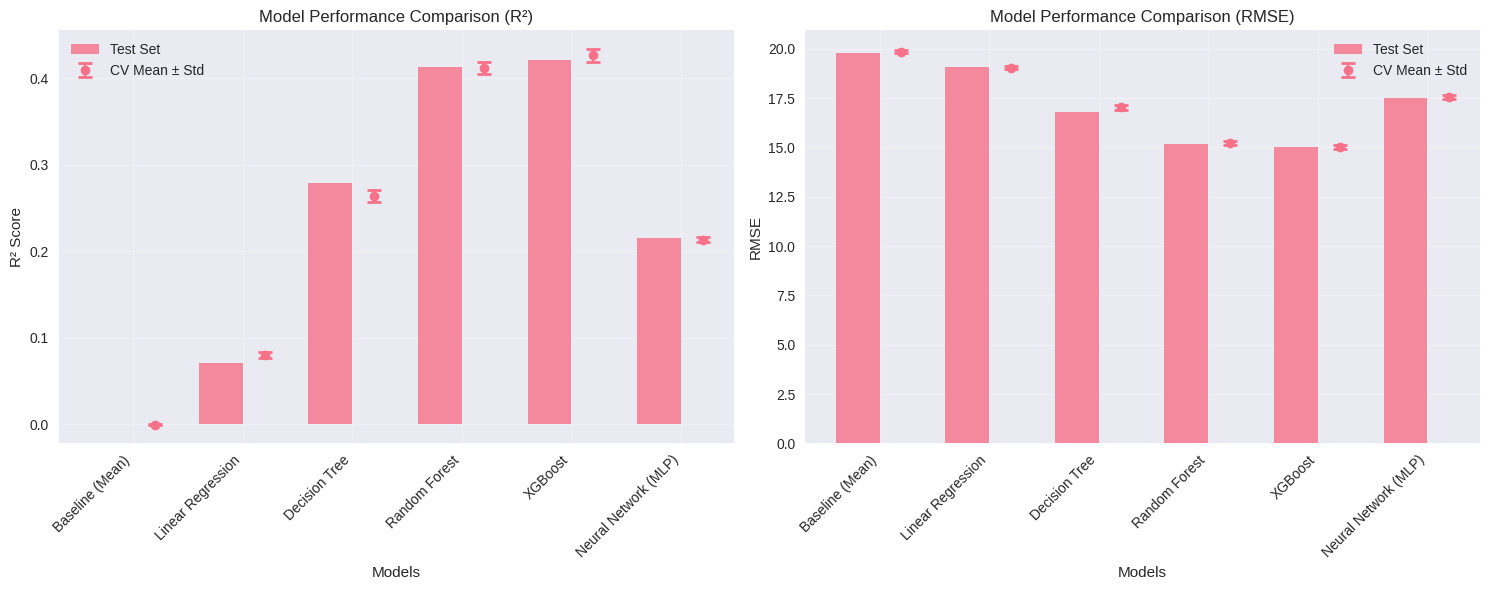

In [ ]:

# Define models with hyperparameter tuning
models = {
    'Baseline (Mean)': DummyRegressor(strategy='mean'),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=50),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15, min_samples_split=20),
    'XGBoost': XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42,n_jobs=-1,verbosity=0),
    'Neural Network (MLP)': MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam')
}

# Train and evaluate models with cross-validation
results = {}
cv_results = {}

print('Training models and performing cross-validation...')
print('=' * 60)

for name, model in models.items():
    print(f'\n Training {name}')

    # Choose which version of the data to use
    if name in ['Linear Regression', 'Baseline (Mean)', 'Neural Network (MLP)']:
        X_train_use, X_test_use = X_train_scaled, X_test_scaled
        cv_X = X_train_scaled
    else:
        X_train_use, X_test_use = X_train, X_test
        cv_X = X_train

    # Cross-validation
    cv_scores = cross_val_score(model, cv_X, y_train, cv=5, scoring='r2', n_jobs=-1)
    cv_rmse_scores = -cross_val_score(model, cv_X, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

    # Train on full training set
    model.fit(X_train_use, y_train)
    y_pred = model.predict(X_test_use)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

    cv_results[name] = {
        'CV_R²_Mean': cv_scores.mean(),
        'CV_R²_Std': cv_scores.std(),
        'CV_RMSE_Mean': cv_rmse_scores.mean(),
        'CV_RMSE_Std': cv_rmse_scores.std()
    }

    print(f'  Test Set Performance:')
    print(f'    RMSE: {rmse:.2f}')
    print(f'    MAE:  {mae:.2f}')
    print(f'    R²:   {r2:.4f}')
    print(f'  Cross-Validation (5-fold):')
    print(f'    R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})')
    print(f'    RMSE:     {cv_rmse_scores.mean():.2f} (±{cv_rmse_scores.std():.2f})')

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
model_names = list(results.keys())
r2_scores = [results[name]['R²'] for name in model_names]
cv_r2_means = [cv_results[name]['CV_R²_Mean'] for name in model_names]
cv_r2_stds = [cv_results[name]['CV_R²_Std'] for name in model_names]

x_pos = np.arange(len(model_names))
axes[0].bar(x_pos - 0.2, r2_scores, 0.4, label='Test Set', alpha=0.8)
axes[0].errorbar(x_pos + 0.2, cv_r2_means, yerr=cv_r2_stds, fmt='o',
                capsize=5, capthick=2, label='CV Mean ± Std')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance Comparison (R²)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE comparison
rmse_scores = [results[name]['RMSE'] for name in model_names]
cv_rmse_means = [cv_results[name]['CV_RMSE_Mean'] for name in model_names]
cv_rmse_stds = [cv_results[name]['CV_RMSE_Std'] for name in model_names]

axes[1].bar(x_pos - 0.2, rmse_scores, 0.4, label='Test Set', alpha=0.8)
axes[1].errorbar(x_pos + 0.2, cv_rmse_means, yerr=cv_rmse_stds, fmt='o',
                capsize=5, capthick=2, label='CV Mean ± Std')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model Performance Comparison (RMSE)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Model Performance Summary**

Among the evaluated models, XGBoost demonstrated the best overall performance in terms of predictive accuracy and generalization.

XGBoost achieved the highest R² score (0.4214), indicating it explains approximately 42.1% of the variance in the target variable. It also recorded the lowest RMSE (15.05) and MAE (11.11), reflecting strong prediction accuracy. Cross-validation results showed excellent stability, with an R² of 0.4265 (±0.0072).

Random Forest followed closely, with an R² of 0.4129 and RMSE of 15.16. It maintained strong generalization, as evidenced by a cross-validation R² of 0.4123 (±0.0069), indicating consistent performance.


**Key Performance Insights**

- XGBoost outperformed Random Forest by 0.0085 R² points on the test set.

- XGBoost showed superior cross-validation performance (0.4265 vs. 0.4123).

- Both tree-based models significantly outperformed the neural network approach.

The performance gap between XGBoost and Random Forest is relatively small, suggesting both are viable options.



## 9. Feature Importance Analysis

Feature Importance Rankings (Random Forest):
 1. genre_encoded       : 0.5151
 2. instrumentalness    : 0.1058
 3. acousticness        : 0.0522
 4. speechiness         : 0.0493
 5. loudness            : 0.0481
 6. energy              : 0.0462
 7. danceability        : 0.0428
 8. energy_danceability : 0.0379
 9. valence             : 0.0371
10. tempo               : 0.0351
11. valence_energy      : 0.0243
12. is_explicit         : 0.0061


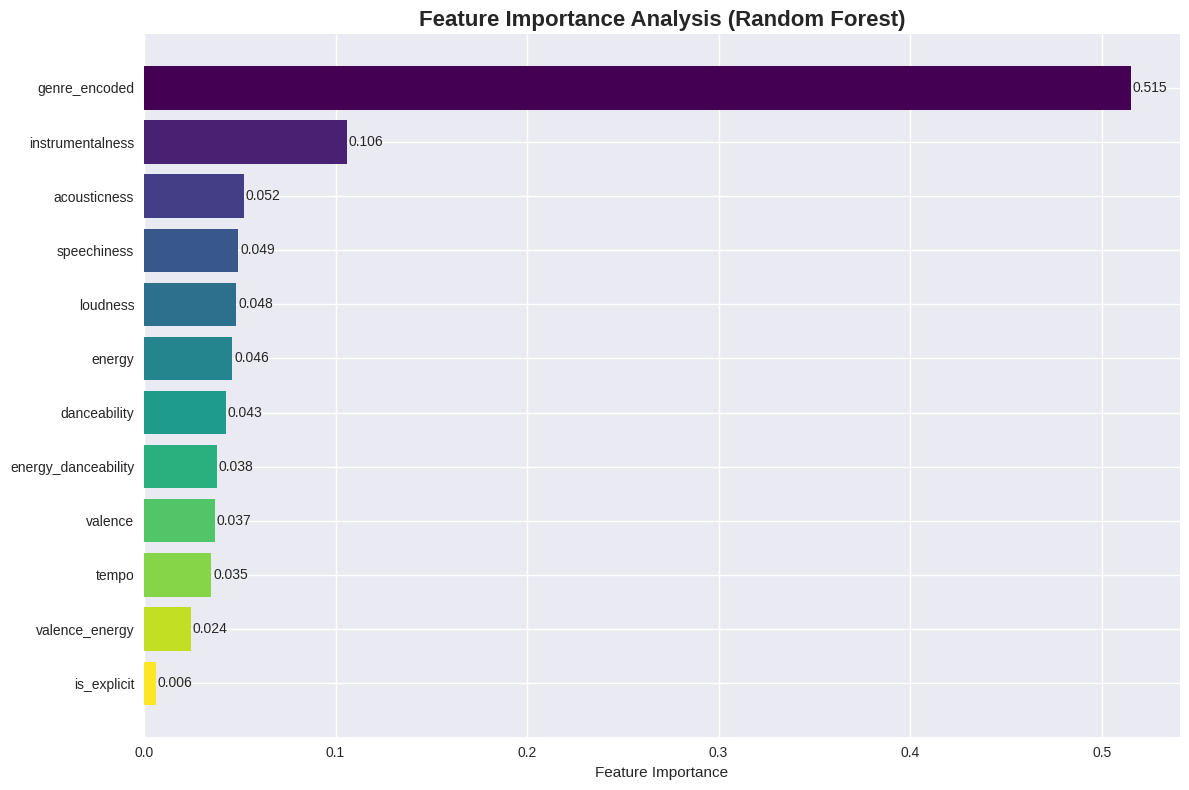

In [ ]:
# Get feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature Importance Rankings (Random Forest):')
print('='*50)
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f'{i:2d}. {row["feature"]:20s}: {row["importance"]:.4f}')

# Enhanced feature importance visualization
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis (Random Forest)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Feature Importance Rankings (XGBoost - Best Model):
 1. genre_encoded       : 0.2783
 2. instrumentalness    : 0.1493
 3. is_explicit         : 0.0872
 4. acousticness        : 0.0728
 5. energy              : 0.0639
 6. speechiness         : 0.0615
 7. loudness            : 0.0593
 8. energy_danceability : 0.0544
 9. valence             : 0.0486
10. danceability        : 0.0482
11. valence_energy      : 0.0408
12. tempo               : 0.0357


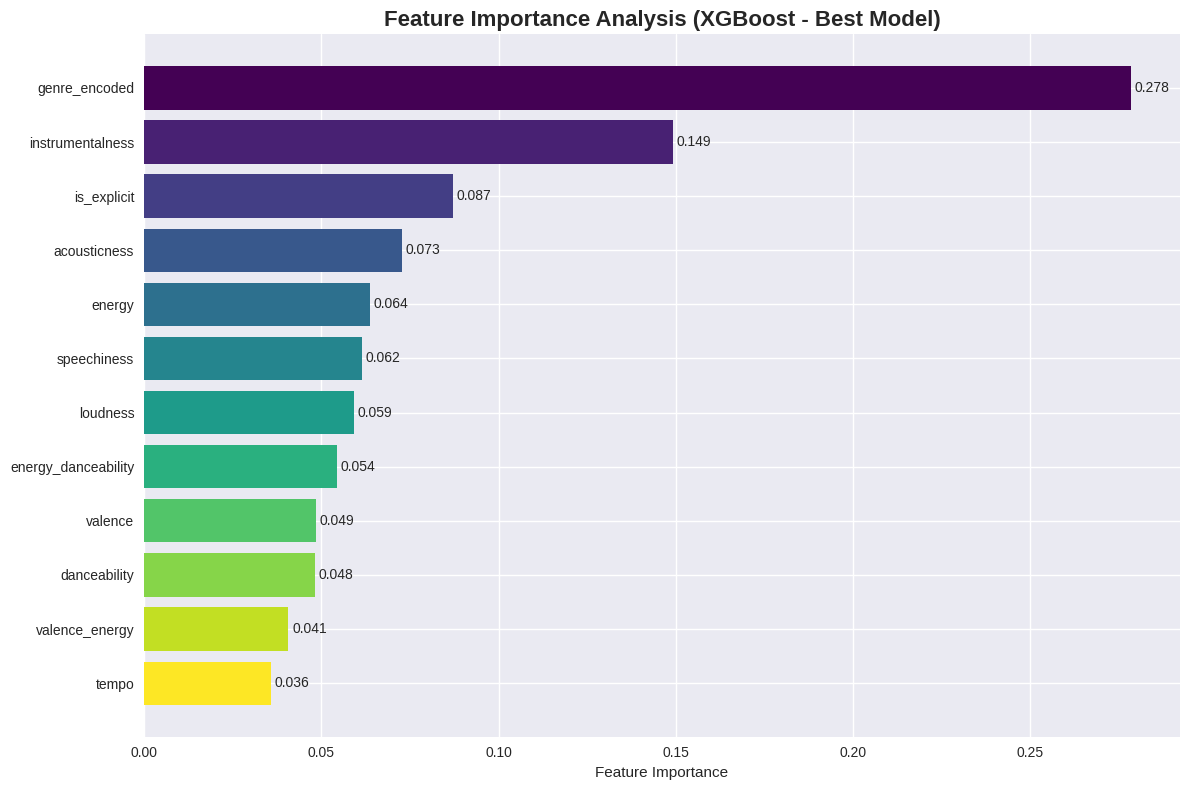

In [ ]:
# Get feature importance from the best model (XGBoost)
best_model = models['XGBoost']
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature Importance Rankings (XGBoost - Best Model):')
print('='*50)
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f'{i:2d}. {row["feature"]:20s}: {row["importance"]:.4f}')

# Enhanced feature importance visualization
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis (XGBoost - Best Model)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


Feature Importance Comparison (Random Forest vs XGBoost):
Feature              RF Rank  XGB Rank  RF Imp   XGB Imp  Diff  
genre_encoded        1        1         0.515    0.278     +0
instrumentalness     2        2         0.106    0.149     +0
is_explicit          12       3         0.006    0.087     +9
acousticness         3        4         0.052    0.073     -1
energy               6        5         0.046    0.064     +1
speechiness          4        6         0.049    0.062     -2
loudness             5        7         0.048    0.059     -2
energy_danceability  8        8         0.038    0.054     +0
valence              9        9         0.037    0.049     +0
danceability         7        10        0.043    0.048     -3
valence_energy       11       11        0.024    0.041     +0
tempo                10       12        0.035    0.036     -2


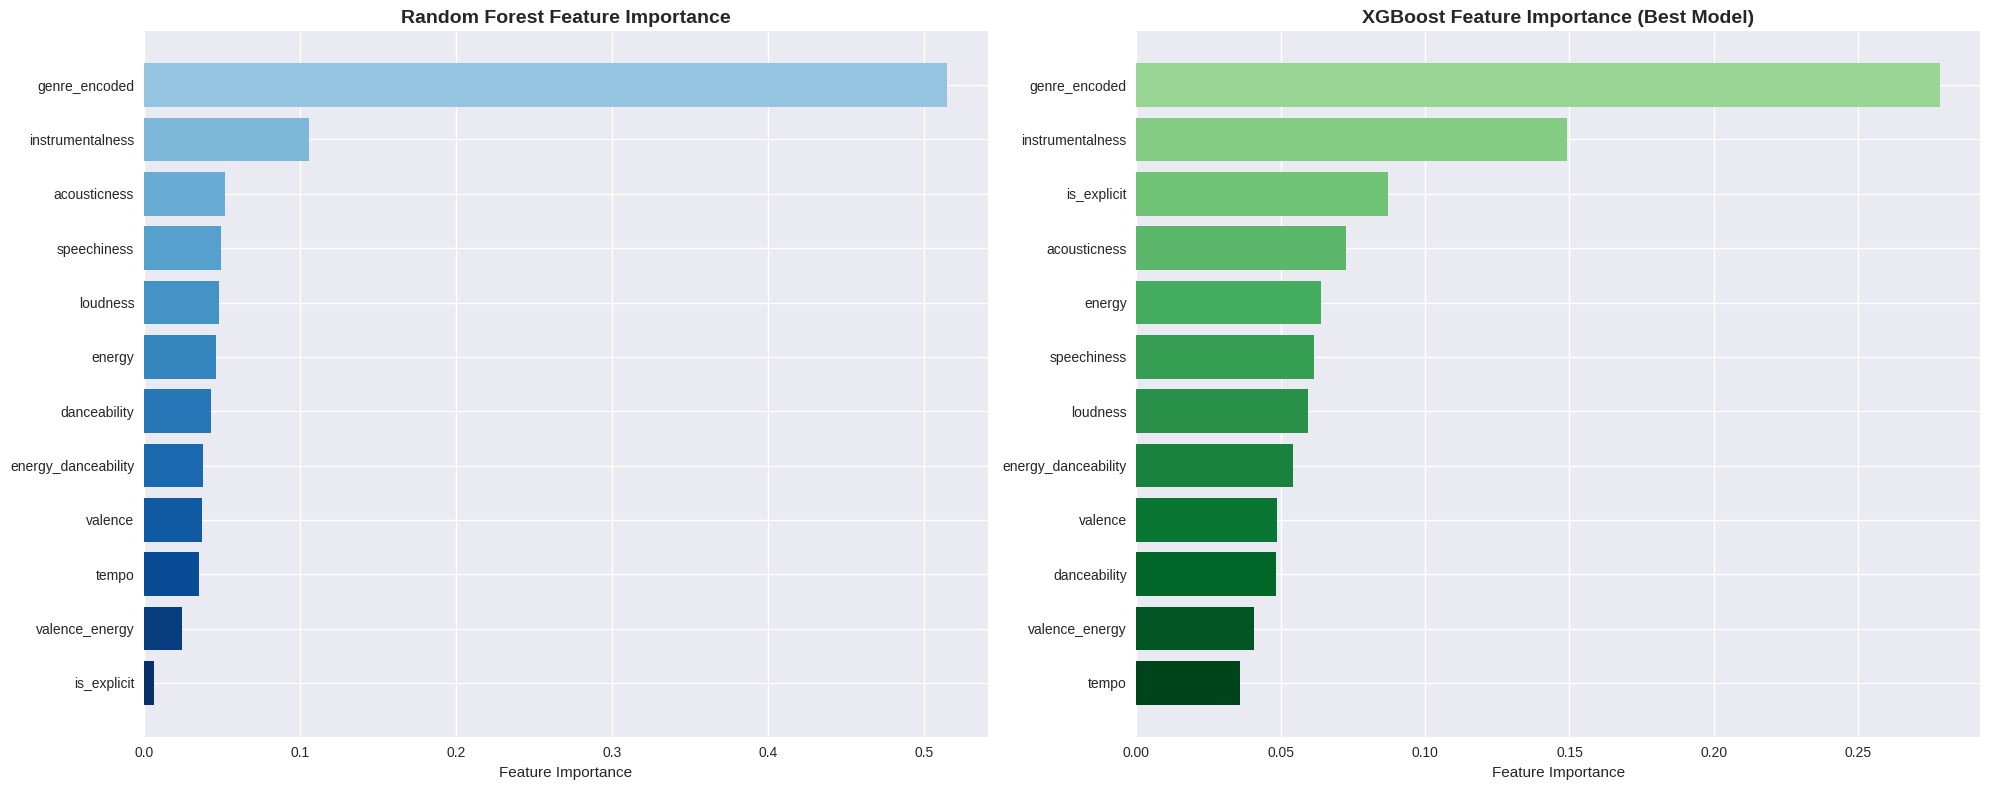

In [ ]:
# Compare feature importance between Random Forest and XGBoost
rf_importance = pd.DataFrame({
    'feature': selected_features,
    'rf_importance': models['Random Forest'].feature_importances_
}).sort_values('rf_importance', ascending=False)

xgb_importance = feature_importance.rename(columns={'importance': 'xgb_importance'})

# Merge for comparison
importance_comparison = pd.merge(rf_importance, xgb_importance, on='feature')
importance_comparison['rank_diff'] = (
    importance_comparison['rf_importance'].rank(ascending=False) -
    importance_comparison['xgb_importance'].rank(ascending=False)
)

print('\nFeature Importance Comparison (Random Forest vs XGBoost):')
print('='*70)
print(f"{'Feature':<20} {'RF Rank':<8} {'XGB Rank':<9} {'RF Imp':<8} {'XGB Imp':<8} {'Diff':<6}")
print('='*70)
for _, row in importance_comparison.sort_values('xgb_importance', ascending=False).iterrows():
    rf_rank = int(importance_comparison['rf_importance'].rank(ascending=False)[importance_comparison['feature'] == row['feature']].iloc[0])
    xgb_rank = int(importance_comparison['xgb_importance'].rank(ascending=False)[importance_comparison['feature'] == row['feature']].iloc[0])
    rank_diff = rf_rank - xgb_rank
    print(f"{row['feature']:<20} {rf_rank:<8} {xgb_rank:<9} {row['rf_importance']:<8.3f} {row['xgb_importance']:<8.3f} {rank_diff:>+3d}")

# Visualization comparing both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest
rf_colors = plt.cm.Blues(np.linspace(0.4, 1, len(rf_importance)))
ax1.barh(range(len(rf_importance)), rf_importance['rf_importance'], color=rf_colors)
ax1.set_yticks(range(len(rf_importance)))
ax1.set_yticklabels(rf_importance['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# XGBoost
xgb_colors = plt.cm.Greens(np.linspace(0.4, 1, len(xgb_importance)))
ax2.barh(range(len(xgb_importance)), xgb_importance['xgb_importance'], color=xgb_colors)
ax2.set_yticks(range(len(xgb_importance)))
ax2.set_yticklabels(xgb_importance['feature'])
ax2.set_xlabel('Feature Importance')
ax2.set_title('XGBoost Feature Importance (Best Model)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 10. Model Analysis and Insights

Best performing model: XGBoost
Performance metrics:
   - Test R² Score: 0.4214
   - Cross-validation R²: 0.4265 (±0.0072)
   - Prediction Error (MAE): ±11.1 popularity points


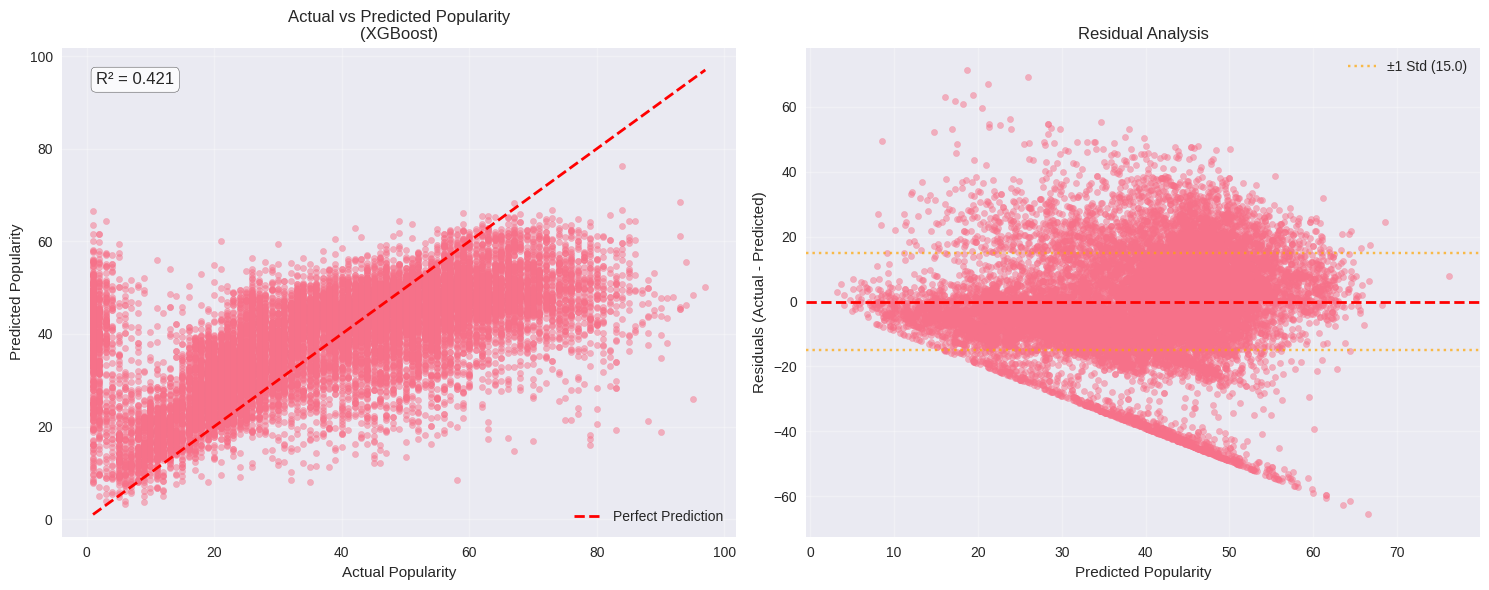


 Model Performance by Popularity Range:
Range  0-20: 2872 songs, R²=-10.834, MAE= 16.5
Range 20-40: 5207 songs, R²=-1.601, MAE=  8.1
Range 40-60: 5559 songs, R²=-1.807, MAE=  7.1
Range 60-80: 2358 songs, R²=-13.605, MAE= 18.4
Range 80-100:  200 songs, R²=-100.037, MAE= 36.3


In [ ]:
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
best_model = models[best_model_name]

print(f'Best performing model: {best_model_name}')
print(f'Performance metrics:')
print(f'   - Test R² Score: {results[best_model_name]["R²"]:.4f}')
print(f'   - Cross-validation R²: {cv_results[best_model_name]["CV_R²_Mean"]:.4f} (±{cv_results[best_model_name]["CV_R²_Std"]:.4f})')
print(f'   - Prediction Error (MAE): ±{results[best_model_name]["MAE"]:.1f} popularity points')

# Prediction vs Actual plot with enhanced visualization
if best_model_name == 'Linear Regression':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with density
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Popularity')
axes[0].set_ylabel('Predicted Popularity')
axes[0].set_title(f'Actual vs Predicted Popularity\n({best_model_name})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add R² annotation
axes[0].text(0.05, 0.95, f'R² = {results[best_model_name]["R²"]:.3f}',
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Residual analysis
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Popularity')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Analysis')
axes[1].grid(True, alpha=0.3)

# Add residual statistics
residual_std = residuals.std()
axes[1].axhline(y=residual_std, color='orange', linestyle=':', alpha=0.7, label=f'±1 Std ({residual_std:.1f})')
axes[1].axhline(y=-residual_std, color='orange', linestyle=':', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

# Performance by popularity ranges
popularity_ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
range_performance = []

print(f'\n Model Performance by Popularity Range:')
print('='*50)
for low, high in popularity_ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 10:  # Only analyze ranges with sufficient data
        range_r2 = r2_score(y_test[mask], y_pred_best[mask])
        range_mae = mean_absolute_error(y_test[mask], y_pred_best[mask])
        range_performance.append({
            'range': f'{low}-{high}',
            'count': mask.sum(),
            'r2': range_r2,
            'mae': range_mae
        })
        print(f'Range {low:2d}-{high:2d}: {mask.sum():4d} songs, R²={range_r2:6.3f}, MAE={range_mae:5.1f}')